# library

In [40]:
# %%capture
# # !pip install -q nnAudio
# !pip install -q --upgrade wandb
# !pip install -q grad-cam
# # !pip install -q ttach
# # !pip install efficientnet_pytorch
# # !pip install albumentations
# !pip install line_profiler
# !pip install transformers
# !pip install audiomentations
# !pip3 install pydub

In [41]:
# !pip install "ipykernel<6"
# !pip install "jupyterlab<3.1"

In [42]:
import os
import gc
import json
import random
from datetime import datetime
import time
import collections
import itertools
from itertools import chain, combinations
import sys
import json
import wandb
from collections import defaultdict
import h5py
from glob import glob
import pickle
import math

import scipy as sp
import numpy as np
np.set_printoptions(precision=5, suppress=True) 

import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import IPython.display
from tqdm.auto import tqdm
from skimage.transform import resize

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as torch_functional
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import (CosineAnnealingWarmRestarts,
                    CosineAnnealingLR, ReduceLROnPlateau,_LRScheduler,CyclicLR)
from torch.cuda.amp import autocast, GradScaler

from transformers import get_cosine_schedule_with_warmup

import audiomentations as A
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, PolarityInversion


In [43]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Configuration

In [44]:
class Config:

    #frequently changed 
    model_name = 'TCNN'
    model_version = "124th_V2SDCBAM_PL_6ep_2em3lr_32ch_vf+gn+sc01+tm+ts" 
    model_module = 'V2SDCBAM'#V2StochasticDepth,ModelIafossV2,V2SDCBAM,BoTCBAMV2SD,
    use_pretrain = False
    use_pseudo_label = True
    up_thresh = 0.70
    down_thresh = 0.15

    debug = False
    use_checkpoint = False
    use_lr_finder = True
    use_subset = False 
    subset_frac = 0.4

    #preproc related
    #augmentation
    #proba for conservative, weight for aggressive
    
    #conservative
    conservative_aug = []#'vflip','add_gaussian_noise',
    #aggressive, OneOf 
    aggressive_aug_proba = 0.80
    aggressive_aug = ['vflip','add_gaussian_noise','shuffle01','timemask','time_shift',]     #'reduce_SNR'
    
    
    vflip = True
    vflip_proba = 0.5
    vflip_weight = 1.0 
    add_gaussian_noise = True 
    add_gaussian_noise_proba = 0.5 
    add_gaussian_noise_weight = 1.0    
    timemask = True
    timemask_proba = 0.35
    timemask_weight = 0.8
    shuffle01 = True
    shuffle01_proba = 0.35
    shuffle01_weight = 0.8
    time_shift = True
    time_shift_left = 96
    time_shift_right = 96
    time_shift_proba = 0.35
    time_shift_weight = 0.4
    
    shift_channel = False
    shift_channel_left = 16
    shift_channel_right = 16
    shift_channel_proba = 0.5
    shift_channel_weight = 1.0
    shift_two_channels = False #tba
    shift_two_channels_proba = 0.5
    shift_two_channels_weight= 1.0
    reduce_SNR = False
    reduce_SNR_ratio = 0.9998
    reduce_SNR_proba = 0.5
    reduce_SNR_weight = 1.0

    time_stretch = False
    divide_std = False 
    shuffle_channels = False    
    pitch_shift = False
    use_mixup = False
    mixup_alpha = 0.1
    cropping = False
    
    #logistic
    seed = 48
    target_size = 1
    target_col = 'target'
    n_fold = 5
#     gdrive = './drive/MyDrive/Kaggle/G2Net/input/'
    kaggle_json_path = 'kaggle/kaggle.json'
    output_dir = "G2Net-Model/"
    pseudo_label_folder = "G2Net-Model/main_112th_V2SD_PL_6ep_5Fold/"#main_35th_GeM_vflip_shuffle01_5fold,#main_112th_V2SD_PL_6ep_5Fold

    #logger
    print_num_steps=350
    
    #training related
    train_folds = [0]
    epochs = 6
    batch_size = 256
    
    lr=  2e-3 #2e-3#8e-3#1e-2#5e-3, 1e-2 # Optimizer  1e-2 channel8, 5e-3 or 2e-3 channel32, 7e-3 channel 16
    weight_decay=0 #1e-4  # Optimizer, default value 0.01
    gradient_accumulation_steps=1 # Optimizer
    scheduler='cosineWithWarmUp' # warm up ratio 0.1 of total steps 
     
    #speedup
    num_workers=7
    non_blocking=False
    amp=True
    use_cudnn = True 
    use_tpu = False
    use_ram = False
    continuous_exp = False
    
    #CNN structure
    channels = 32
    reduction = 1.0
    stochastic_final_layer_proba = 0.8
    CBAM_SG_kernel_size = 15

# no need to change below
Config.model_output_folder = Config.output_dir + Config.model_version + "/"
if not os.path.exists(Config.output_dir):
    os.mkdir(Config.output_dir)
if not os.path.exists(Config.model_output_folder):
    os.mkdir(Config.model_output_folder)

torch.backends.cudnn.benchmark = Config.use_cudnn 
display(Config.model_output_folder)

'G2Net-Model/124th_V2SDCBAM_PL_6ep_2em3lr_32ch_vf+gn+sc01+tm+ts/'

In [45]:
# #run once for Fold 0, save it in RAM and then do experiments multiple times       
# if Config.continuous_exp and Config.train_folds == [0]:
#     start_time =time.time()  
#     if Config.use_pseudo_label:
#         with open('fold_0_data_PL.npy', 'rb') as f:
#             fold_0_data_PL = np.load(f)
#     else:
#         with open('fold_0_data.npy', 'rb') as f:
#             fold_0_data = np.load(f)
#     print(time.time()-start_time)

# wandb

In [46]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

save_object(class2dict(Config), Config.model_output_folder + "Config.pkl")

# Data path

In [47]:
def id_2_path(file_id: str, train=True) -> str:
    if train:
        return "./output/whiten-train-w0/{}.npy".format(file_id)
    else:
        return "./output/whiten-test-w0/{}.npy".format(file_id)

In [48]:
train_df = pd.read_csv('training_labels.csv')
test_df = pd.read_csv('sample_submission.csv')
if Config.debug:
    Config.epochs = 1
    train_df = train_df.sample(n=50000, random_state=Config.seed).reset_index(drop=True)
if Config.use_subset:
    train_df = train_df.sample(frac=Config.subset_frac, random_state=Config.seed).reset_index(drop=True)
train_df['file_path'] = train_df['id'].apply(lambda x :id_2_path(x))
test_df['file_path'] = test_df['id'].apply(lambda x :id_2_path(x,False))

In [49]:
# checking magnitude of waves
num_files = 5
input_file_paths = train_df['file_path'].values[:num_files]
batch_waves=np.zeros((num_files,3,4096))
for i,input_file_path in enumerate(input_file_paths[:num_files]):
    file_name = input_file_path.split('/')[-1].split('.npy')[0]
    waves = np.load(input_file_path)#.astype(np.float32) # (3, 4096)
#     batch_waves[i,:] = np.array([waves.max(axis=1),np.abs(waves).max(axis=1),np.abs(waves).min(axis=1)])
    whitened_waves = waves#whiten(waves)
    print(whitened_waves[2][500])

-0.013057893
0.01869043
0.005618966
-0.01463365
0.010516807


In [50]:
# !!
skf = StratifiedKFold(n_splits=Config.n_fold, shuffle=True, random_state=Config.seed)
splits = skf.split(train_df, train_df["target"])
train_df['fold'] = -1
for fold, (train_index, valid_index) in enumerate(splits):
    train_df.loc[valid_index,"fold"] = fold
# train_df['fold_PL'] = train_df['fold']

train_df.groupby('fold')['target'].apply(lambda s: s.value_counts(normalize=True))

fold   
0     0    0.500125
      1    0.499875
1     0    0.500125
      1    0.499875
2     0    0.500125
      1    0.499875
3     0    0.500125
      1    0.499875
4     0    0.500125
      1    0.499875
Name: target, dtype: float64

In [51]:
train_df

,id,target,file_path,fold
0,00000e74ad,1,./output/whiten-train-w0/00000e74ad.npy,3
1,00001f4945,0,./output/whiten-train-w0/00001f4945.npy,0
2,0000661522,0,./output/whiten-train-w0/0000661522.npy,4
3,00007a006a,0,./output/whiten-train-w0/00007a006a.npy,0
4,0000a38978,1,./output/whiten-train-w0/0000a38978.npy,4
...,...,...,...,...
559995,ffff9a5645,1,./output/whiten-train-w0/ffff9a5645.npy,3
559996,ffffab0c27,0,./output/whiten-train-w0/ffffab0c27.npy,1
559997,ffffcf161a,1,./output/whiten-train-w0/ffffcf161a.npy,2
559998,ffffd2c403,0,./output/whiten-train-w0/ffffd2c403.npy,1


# Model

## dataset

In [52]:
conserv_transform_list = []
aggressive_transform_list = []
conserv_transform_list_strings = []
aggressive_transform_list_strings = []

#-------------------------vflip
if Config.vflip:
#     trans = lambda x:-x
    def vflip_func(x,sample_rate=2048):
        return -x
    def vflip_func_random(x,sample_rate=2048):
        if np.random.random()<Config.vflip_proba:
            return -x
        else:
            return x
    if 'vflip' in Config.aggressive_aug:
        aggressive_transform_list.append(vflip_func)
        aggressive_transform_list_strings.append('vflip')
    else:
        conserv_transform_list.append(vflip_func_random)
        conserv_transform_list_strings.append('vflip')
#----------------------add_gaussian_noise        
if Config.add_gaussian_noise:
    
    if 'add_gaussian_noise' in Config.aggressive_aug:
        trans = A.AddGaussianNoise(min_amplitude=0.001*0.015, max_amplitude=0.015*0.015, p=1) #tbs #0.015 is the estimated std
        aggressive_transform_list.append(trans)
        aggressive_transform_list_strings.append('add_gaussian_noise')
    else:
        trans = A.AddGaussianNoise(min_amplitude=0.001*0.015, max_amplitude=0.015*0.015, p=Config.add_gaussian_noise_proba) #tbs #0.015 is the estimated std
        conserv_transform_list.append(trans)
        conserv_transform_list_strings.append('add_gaussian_noise')

#--------------------------timemask
if Config.timemask:
    
    if 'timemask' in Config.aggressive_aug:
        trans = A.TimeMask(min_band_part=0.0, max_band_part=0.03, fade=False, p=1)
        aggressive_transform_list.append(trans)
        aggressive_transform_list_strings.append('timemask')
    else:
        trans = A.TimeMask(min_band_part=0.0, max_band_part=0.03, fade=False, p=Config.timemask_proba)
        conserv_transform_list.append(trans)
        conserv_transform_list_strings.append('timemask')

#--------------------------shuffle01        
def shuffle01_func(x,sample_rate=2048):
    return x[[1,0,2]]
def shuffle01_func_random(x,sample_rate=2048):
    if np.random.random()<Config.shuffle01_proba: 
        return x[[1,0,2]]
    else:
        return x
if Config.shuffle01:
#     trans = lambda x:x[[1,0,2]]

    if 'shuffle01' in Config.aggressive_aug:
        aggressive_transform_list.append(shuffle01_func)
        aggressive_transform_list_strings.append('shuffle01')
    else:
        conserv_transform_list.append(shuffle01_func_random)
        conserv_transform_list_strings.append('shuffle01')
#---------------------------time_shift
if Config.time_shift:
    if 'time_shift' in Config.aggressive_aug:
        trans = A.Shift(min_fraction=-Config.time_shift_left*1.0/4096,
                        max_fraction=Config.time_shift_right*1.0/4096, 
                        p=1,rollover=False)#<0 means shift towards left,  fraction of total sound length
        aggressive_transform_list.append(trans)
        aggressive_transform_list_strings.append('time_shift')
    else:
        trans = A.Shift(min_fraction=-Config.time_shift_left*1.0/4096,
                                max_fraction=Config.time_shift_right*1.0/4096, 
                                p=Config.time_shift_proba,rollover=False)
        conserv_transform_list.append(trans)
        conserv_transform_list_strings.append('time_shift')

#-----------------shift_channel        
def shift_channel_func(x,sample_rate=2048):
    channel = np.random.choice(3)
    trans = A.Shift(min_fraction=-Config.shift_channel_left*1.0/4096,
                max_fraction=Config.shift_channel_right*1.0/4096, 
                p=1,rollover=False)
    x[channel] = trans(x[channel],sample_rate=2048)
    return x
def shift_channel_func_random(x,sample_rate=2048):
    channel = np.random.choice(3)
    trans = A.Shift(min_fraction=-Config.shift_channel_left*1.0/4096,
                max_fraction=Config.shift_channel_right*1.0/4096, 
                p=Config.shift_channel_proba,rollover=False)
    x[channel] = trans(x[channel],sample_rate=2048)
    return x
if Config.shift_channel:
    if 'shift_channel' in Config.aggressive_aug:
        
        aggressive_transform_list.append(shift_channel_func)
        aggressive_transform_list_strings.append('shift_channel')
    else:
        
        conserv_transform_list.append(shift_channel_func_random)
        conserv_transform_list_strings.append('shift_channel')
#-----------------reduce_SNR        
def reduce_SNR_func(x,sample_rate=2048):
    x = x * Config.reduce_SNR_ratio
    trans = A.AddGaussianNoise(min_amplitude=multiplier, max_amplitude=multiplier, p=1)
    x = trans(x,sample_rate=2048)
    return x 
def reduce_SNR_func_random(x,sample_rate=2048):
    if np.random.random() < Config.reduce_SNR_proba:
        x = x * Config.reduce_SNR_ratio
        trans = A.AddGaussianNoise(min_amplitude=multiplier, max_amplitude=multiplier, p=1)
        x = trans(x,sample_rate=2048)
    return x
if Config.reduce_SNR:
    multiplier = math.sqrt(1-Config.reduce_SNR_ratio**2)
    if 'reduce_SNR' in Config.aggressive_aug:

        aggressive_transform_list.append(reduce_SNR_func)
        aggressive_transform_list_strings.append('reduce_SNR')
    else:

        conserv_transform_list.append(reduce_SNR_func_random)
        conserv_transform_list_strings.append('reduce_SNR')
        
# if Config.time_stretch:
#     trans = A.TimeStretch(min_rate=0.98, max_rate=1.02,leave_length_unchanged=True, p=0.5)
#     if 'time_stretch' in aggressive_aug:
#         aggressive_transform_list.append(trans)
#         aggressive_transform_list_strings.append('time_stretch')
#     else:
#         conserv_transform_list.append(trans)
#         conserv_transform_list_strings.append('time_stretch')
# if Config.pitch_shift:
#     trans = A.PitchShift(min_semitones=-1, max_semitones=1, p=0.5)
#     if 'pitch_shift' in aggressive_aug:
#         aggressive_transform_list.append(trans)
#         aggressive_transform_list_strings.append('pitch_shift')
#     else:
#         conserv_transform_list.append(trans)
#         conserv_transform_list_strings.append('pitch_shift')
# if Config.shift_channel:
#     pass

print('conservative transforms: ',conserv_transform_list_strings)
print('aggressive transforms: ',aggressive_transform_list_strings)
train_transform = conserv_transform_list#A.Compose(conserv_transform_list)#,OneOf(aggressive_transform_list,p=0.5)) # no OneOf in audiomentation
# 

test_transform = None #A.Compose([])

conservative transforms:  []
aggressive transforms:  ['vflip', 'add_gaussian_noise', 'timemask', 'shuffle01', 'time_shift']


In [53]:
# [getattr(Config(), f'{agg}_weight') for agg in aggressive_transform_list_strings]

In [54]:
class DataRetriever(Dataset):
    def __init__(self, paths, targets, transforms=None):
        self.paths = paths
        self.targets = targets
        self.transforms = transforms


        #reading data for fold 0 for fast iteration
        if Config.continuous_exp and Config.train_folds == [0]:
            if Config.use_pseudo_label:
                self.data = fold_0_data_PL
            else:
                self.data = fold_0_data
        else:
            if Config.use_ram:
                start_time =time.time()
                array_shape = (len(self.paths),3,4096)
                self.data = np.zeros(array_shape,dtype=np.float32)
                for i,path in enumerate(self.paths):
                    waves = np.load(path)
                    self.data[i,:] = waves            
                print(time.time()-start_time)

                
            # saving Fold 0 data for later use
#         with open('fold_0_data_PL.npy', 'wb') as f:
#             np.save(f, self.data)



    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        if Config.use_ram:
            waves = self.data[index]
        else:
            path = self.paths[index] 
            waves = np.load(path)
#         if Config.cropping:
#             waves = waves[:,1792:3840+1]

#         if Config.divide_std:
#             waves /= 0.015 #causing NaN?

#         if Config.shuffle_channels:#nn.ChannelShuffle
#             if np.random.random()<0.5:
#                 np.random.shuffle(waves)
                
#         if Config.vflip:
#             if np.random.random()<0.5:
#                 waves = -waves
            
        if self.transforms is not None:
            for i,_ in enumerate(self.transforms):
                transform = conserv_transform_list[i]
                waves= transform(waves,sample_rate=2048)
            
        if aggressive_transform_list_strings:
            if np.random.random()<Config.aggressive_aug_proba:
                n = len(aggressive_transform_list_strings)
                probas = np.array([getattr(Config(), f'{agg}_weight') for agg in aggressive_transform_list_strings])
                probas /= probas.sum()
                trans_idx = np.random.choice(n,p=probas)
                trans = aggressive_transform_list[trans_idx]
                waves = trans(waves,sample_rate=2048)


        waves = torch.from_numpy(waves) 
        # if Config.ta:#on tensor, batch*channel*ts
        #     waves = self.ta_augment(waves,sample_rate=2048)
        target = torch.tensor(self.targets[index],dtype=torch.float)#device=device, 
            
        return (waves, target)

class DataRetrieverTest(Dataset):
    def __init__(self, paths, targets, transforms=None):
        self.paths = paths
        self.targets = targets
        self.transforms = transforms
        if Config.use_ram:
            array_shape = (len(self.paths),3,4096)
            self.data = np.zeros(array_shape,dtype=np.float32)
            for i,path in enumerate(self.paths):
                waves = np.load(path)
                self.data[i,:] = waves  

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):

        if Config.use_ram:
            waves = self.data[index]
        else:
            path = self.paths[index] 
            waves = np.load(path)
            
#         if Config.cropping:
#             waves = waves[:,1792:3840+1]
            
#         if Config.divide_std:
#             waves /= 0.015

        if self.transforms is not None:
            waves= self.transforms(waves,sample_rate=2048)
        waves = torch.from_numpy(waves) 
        target = torch.tensor(self.targets[index],dtype=torch.float)#device=device, 
            
        return (waves, target)

class DataRetrieverLRFinder(Dataset):
    def __init__(self, paths, targets, transforms=None):
        self.paths = paths
        self.targets = targets
        self.transforms = transforms     
#         start_time =time.time()
#         array_shape = (len(self.paths),3,4096)
#         self.data = np.zeros(array_shape,dtype=np.float32)
#         for i,path in enumerate(self.paths):
#             waves = np.load(path)
#             self.data[i,:] = waves
#         print(time.time()-start_time)


    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        
        path = self.paths[index] 
        waves = np.load(path)
        
#         if Config.cropping:
#             waves = waves[:,1792:3840+1]

#         if Config.divide_std:
#             waves /= 0.015

#         if Config.shuffle_channels:
#             if np.random.random()<0.5:
#                 np.random.shuffle(waves)
#         if Config.shuffle01:
#             if np.random.random()<0.5:
#                 waves[[0,1]]=waves[[1,0]]
#         if Config.vflip:
#             if np.random.random()<0.5:
#                 waves = -waves
              
        if self.transforms is not None:
            waves= self.transforms(waves,sample_rate=2048)
        waves = torch.from_numpy(waves) 
        # if Config.ta:#on tensor, batch*channel*ts
        #     waves = self.ta_augment(waves,sample_rate=2048)
        target = torch.tensor(self.targets[index],dtype=torch.float)#device=device, 
            
        return (waves, target)

In [55]:
# len(aggressive_transform_list)


In [56]:
# np.random.choice(5,p=[0.1, 0, 0.3, 0.6, 0])

In [57]:
class GeM(nn.Module):
    '''
    Code modified from the 2d code in
    https://amaarora.github.io/2020/08/30/gempool.html
    '''
    def __init__(self, kernel_size=8, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.kernel_size = kernel_size
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        with torch.cuda.amp.autocast(enabled=False):#to avoid NaN issue for fp16
            return torch_functional.avg_pool1d(x.clamp(min=eps).pow(p), self.kernel_size).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'


In [58]:
#https://www.kaggle.com/iafoss/mish-activation
import torch.nn.functional as F
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_tensors[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

## neural net

In [59]:
class ModelCNN_Dilations(nn.Module):
    """1D convolutional neural network with dilations. Classifier of the gravitaitonal waves
    Inspired by the https://arxiv.org/pdf/1904.08693.pdf
    """

    def __init__(self):
        super().__init__()
        self.init_conv = nn.Sequential(nn.Conv1d(3, 256, kernel_size=1), nn.ReLU())
        self.convs = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv1d(256, 256, kernel_size=2, dilation=2 ** i),
                    nn.ReLU(),
                )
                for i in range(11)
            ]
        )
        self.out_conv = nn.Sequential(nn.Conv1d(256, 1, kernel_size=1), nn.ReLU())
        self.fc = nn.Linear(2049, 1)

    def forward(self, x):
        x = self.init_conv(x)
        for conv in self.convs:
            x = conv(x)
        x = self.out_conv(x)
        x = self.fc(x)
        x.squeeze_(1)
        return x


class Model1DCNN(nn.Module):
    """1D convolutional neural network. Classifier of the gravitational waves.
    Architecture from there https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.141103
    """

    def __init__(self, initial_channnels=8):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d(3, initial_channnels, kernel_size=64),
            nn.BatchNorm1d(initial_channnels),
            nn.ELU(),
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(initial_channnels, initial_channnels, kernel_size=32),
            nn.MaxPool1d(kernel_size=8),
            nn.BatchNorm1d(initial_channnels),
            nn.ELU(),
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(initial_channnels, initial_channnels * 2, kernel_size=32),
            nn.BatchNorm1d(initial_channnels * 2),
            nn.ELU(),
        )
        self.cnn4 = nn.Sequential(
            nn.Conv1d(initial_channnels * 2, initial_channnels * 2, kernel_size=16),
            nn.MaxPool1d(kernel_size=6),
            nn.BatchNorm1d(initial_channnels * 2),
            nn.ELU(),
        )
        self.cnn5 = nn.Sequential(
            nn.Conv1d(initial_channnels * 2, initial_channnels * 4, kernel_size=16),
            nn.BatchNorm1d(initial_channnels * 4),
            nn.ELU(),
        )
        self.cnn6 = nn.Sequential(
            nn.Conv1d(initial_channnels * 4, initial_channnels * 4, kernel_size=16),
            nn.MaxPool1d(kernel_size=4),
            nn.BatchNorm1d(initial_channnels * 4),
            nn.ELU(),
        )
        if Config.cropping:
            fm_size = tbd
        else:
            fm_size = 11
        self.fc1 = nn.Sequential(
            nn.Linear(initial_channnels * 4 * fm_size, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.ELU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.ELU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.cnn5(x)
        x = self.cnn6(x)
        # print(x.shape)
        x = x.flatten(1)
        # x = x.mean(-1)
        # x = torch.cat([x.mean(-1), x.max(-1)[0]])
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    
class Model1DCNNGEM(nn.Module):
    """1D convolutional neural network. Classifier of the gravitational waves.
    Architecture from there https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.141103
    """

    def __init__(self, initial_channnels=8):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d(3, initial_channnels, kernel_size=64),
            nn.BatchNorm1d(initial_channnels),
            nn.ELU(),
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(initial_channnels, initial_channnels, kernel_size=32),
            GeM(kernel_size=8),
            nn.BatchNorm1d(initial_channnels),
            nn.ELU(),
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(initial_channnels, initial_channnels * 2, kernel_size=32),
            nn.BatchNorm1d(initial_channnels * 2),
            nn.ELU(),
        )
        self.cnn4 = nn.Sequential(
            nn.Conv1d(initial_channnels * 2, initial_channnels * 2, kernel_size=16),
            GeM(kernel_size=6),
            nn.BatchNorm1d(initial_channnels * 2),
            nn.ELU(),
        )
        self.cnn5 = nn.Sequential(
            nn.Conv1d(initial_channnels * 2, initial_channnels * 4, kernel_size=16),
            nn.BatchNorm1d(initial_channnels * 4),
            nn.ELU(),
        )
        self.cnn6 = nn.Sequential(
            nn.Conv1d(initial_channnels * 4, initial_channnels * 4, kernel_size=16),
            GeM(kernel_size=4),
            nn.BatchNorm1d(initial_channnels * 4),
            nn.ELU(),
        )
        if Config.cropping:
            fm_size = tbd
        else:
            fm_size = 11
        self.fc1 = nn.Sequential(
            nn.Linear(initial_channnels * 4 * fm_size, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.ELU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.ELU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.cnn5(x)
        x = self.cnn6(x)
        # print(x.shape)
        x = x.flatten(1)
        # x = x.mean(-1)
        # x = torch.cat([x.mean(-1), x.max(-1)[0]])
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x    

#--------------------------------------------------------------------------- V0
class ExtractorMaxPool(nn.Sequential):
    def __init__(self, in_c=8, out_c=8, kernel_size=64, maxpool=8, act=nn.SiLU(inplace=True)):
        super().__init__(
            nn.Conv1d(in_c, out_c, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(out_c), act,
            nn.Conv1d(out_c, out_c, kernel_size=kernel_size, padding=kernel_size//2),
            nn.MaxPool1d(kernel_size=maxpool),
        )

class ResBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, kernel_size=3, act=nn.SiLU(inplace=True)):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size,
                      padding=kernel_size//2, bias=False),
            nn.BatchNorm1d(out_planes), act,
            nn.Conv1d(out_planes, out_planes, kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size//2, bias=False),
            nn.BatchNorm1d(out_planes))
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_planes)
            )
        self.act = act
        
    def forward(self, x):
        return self.act(self.conv(x) + self.shortcut(x))


class ModelIafoss(nn.Module):
    def __init__(self, n=8, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(ExtractorMaxPool(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),),
            nn.Sequential(ExtractorMaxPool(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),)
        ])
        self.conv = nn.Sequential(
            ResBlock(3*n,2*n,kernel_size=31,stride=4),
            ResBlock(2*n,2*n,kernel_size=31),
            ResBlock(2*n,4*n,kernel_size=15,stride=4),
            ResBlock(4*n,4*n,kernel_size=15),
            ResBlock(4*n,8*n,kernel_size=7,stride=4),
            ResBlock(8*n,8*n,kernel_size=7),
        )
        self.head = nn.Sequential(nn.Flatten(),
            nn.Linear(n*8*8,256),nn.BatchNorm1d(256),nn.Dropout(ps), act,
            nn.Linear(256, 256),nn.BatchNorm1d(256),nn.Dropout(ps), act,
            nn.Linear(256, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))


#----------------------------------------------V1    
    
class AdaptiveConcatPool1d(nn.Module):
    "Layer that concats `AdaptiveAvgPool1d` and `AdaptiveMaxPool1d`"
    def __init__(self, size=None):
        super().__init__()
        self.size = size or 1
        self.ap = nn.AdaptiveAvgPool1d(self.size)
        self.mp = nn.AdaptiveMaxPool1d(self.size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

# using GeM
class Extractor(nn.Sequential):
    def __init__(self, in_c=8, out_c=8, kernel_size=64, maxpool=8, act=nn.SiLU(inplace=True)):
        super().__init__(
            nn.Conv1d(in_c, out_c, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(out_c), act,
            nn.Conv1d(out_c, out_c, kernel_size=kernel_size, padding=kernel_size//2),
#             nn.MaxPool1d(kernel_size=maxpool),
            GeM(kernel_size=maxpool),
        )
    
class ModelIafossV1(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlock(3*n,3*n,kernel_size=31,stride=4), #512
            ResBlock(3*n,3*n,kernel_size=31), #128
            ResBlock(3*n,4*n,kernel_size=15,stride=4), #128
            ResBlock(4*n,4*n,kernel_size=15), #32
            ResBlock(4*n,8*n,kernel_size=7,stride=4), #32
            ResBlock(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))

#for SE-----------------------------------------------------------------------------
class SELayer(nn.Module):
    def __init__(self, channel, reduction):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, int(channel // reduction), bias=False),
            nn.SiLU(inplace=True),
            nn.Linear(int(channel // reduction), channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class SEResBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, kernel_size=3, act=nn.SiLU(inplace=True),reduction=Config.reduction):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size,
                      padding=kernel_size//2, bias=False),
            nn.BatchNorm1d(out_planes), act,
            nn.Conv1d(out_planes, out_planes, kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size//2, bias=False),
            nn.BatchNorm1d(out_planes),
            SELayer(out_planes, reduction)
        )
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_planes)
            )
        self.act = act

    def forward(self, x):
        return self.act(self.conv(x) + self.shortcut(x))

class ModelIafossV1SE(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            SEResBlock(3*n,3*n,kernel_size=31,stride=4), #512
            SEResBlock(3*n,3*n,kernel_size=31), #128
            SEResBlock(3*n,4*n,kernel_size=15,stride=4), #128
            SEResBlock(4*n,4*n,kernel_size=15), #32
            SEResBlock(4*n,8*n,kernel_size=7,stride=4), #32
            SEResBlock(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[1](x[:,1].unsqueeze(1)),
            self.ex[2](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))
    
#for CBAM-----------------------------------------------------------------------
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, silu=True):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm1d(out_planes,eps=1e-5, momentum=0.01, affine=True) #0.01,default momentum 0.1
        self.silu = nn.SiLU(inplace=True) if silu else None

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.silu is not None:
            x = self.silu(x)
        return x
    
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )
class SpatialGate(nn.Module):
    def __init__(self,kernel_size=15):
        super(SpatialGate, self).__init__()
        kernel_size = kernel_size
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, silu=True)#silu False
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out) # broadcasting
        return x * scale
    
class CBAMResBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, kernel_size=3, act=nn.SiLU(inplace=True),reduction=Config.reduction):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size,
                      padding=kernel_size//2, bias=False),
            nn.BatchNorm1d(out_planes), act,
            nn.Conv1d(out_planes, out_planes, kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size//2, bias=False),
            nn.BatchNorm1d(out_planes),
            SELayer(out_planes, reduction),
            SpatialGate(),
        )
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_planes)
            )
        self.act = act

    def forward(self, x):
        return self.act(self.conv(x) + self.shortcut(x))
    
class ModelIafossV1CBAM(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),CBAMResBlock(n,n,kernel_size=31,stride=4),
                          CBAMResBlock(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),CBAMResBlock(n,n,kernel_size=31,stride=4),
                          CBAMResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            CBAMResBlock(3*n,3*n,kernel_size=31,stride=4), #512
            CBAMResBlock(3*n,3*n,kernel_size=31), #128
            CBAMResBlock(3*n,4*n,kernel_size=15,stride=4), #128
            CBAMResBlock(4*n,4*n,kernel_size=15), #32
            CBAMResBlock(4*n,8*n,kernel_size=7,stride=4), #32
            CBAMResBlock(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))    

#---------------------------------------------------------------------------------------------------  
    
    
class BasicBlockPool(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, downsample=1, act=nn.SiLU(inplace=True)):
        super().__init__()
        self.act = act
        if downsample != 1 or in_channels != out_channels:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.MaxPool1d(downsample,ceil_mode=True), # downsampling 
            )
            self.shortcut = nn.Sequential(
                    nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                    nn.BatchNorm1d(out_channels),
                    nn.MaxPool1d(downsample,ceil_mode=True),  # downsampling 
                )#skip layers in residual_function, can try simple MaxPool1d
#             self.shortcut = nn.Sequential(
#                     nn.MaxPool1d(2,ceil_mode=True),  # downsampling 
#                 )
        else:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
            )
    #             self.shortcut = nn.Sequential(
    #                     nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
    #                     nn.BatchNorm1d(out_channels),
    #                 )#skip layers in residual_function, can try identity, i.e., nn.Sequential()
            self.shortcut = nn.Sequential()

    def forward(self, x):
        return self.act(self.residual_function(x) + self.shortcut(x))

class ModelIafossV1Pool(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            BasicBlockPool(3*n,3*n,kernel_size=31,downsample=4), #512
            BasicBlockPool(3*n,3*n,kernel_size=31), #128
            BasicBlockPool(3*n,4*n,kernel_size=15,downsample=4), #128
            BasicBlockPool(4*n,4*n,kernel_size=15), #32
            BasicBlockPool(4*n,8*n,kernel_size=7,downsample=4), #32
            BasicBlockPool(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))

#---------------------------------------------------------------------------------------------------  
    
    
class ResBlockGeM(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, downsample=1, act=nn.SiLU(inplace=True)):
        super().__init__()
        self.act = act
        if downsample != 1 or in_channels != out_channels:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                GeM(kernel_size=downsample), # downsampling 
            )
            self.shortcut = nn.Sequential(
                    nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                    nn.BatchNorm1d(out_channels),
                    GeM(kernel_size=downsample),  # downsampling 
                )#skip layers in residual_function, can try simple MaxPool1d
        else:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
            )
            self.shortcut = nn.Sequential()

    def forward(self, x):
        return self.act(self.residual_function(x) + self.shortcut(x))

class ModelIafossV1GeM(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=4), #512
            ResBlockGeM(3*n,3*n,kernel_size=31), #128
            ResBlockGeM(3*n,4*n,kernel_size=15,downsample=4), #128
            ResBlockGeM(4*n,4*n,kernel_size=15), #32
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=4), #32
            ResBlockGeM(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))
#-----------------------------------------------------------------------------
class ModelIafossV1GeMAll(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=4), #512
            ResBlockGeM(3*n,3*n,kernel_size=31), #128
            ResBlockGeM(3*n,4*n,kernel_size=15,downsample=4), #128
            ResBlockGeM(4*n,4*n,kernel_size=15), #32
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=4), #32
            ResBlockGeM(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))

#-----------------------------------------------------------------------------    
class AdaptiveConcatPool1dx3(nn.Module):
    "Layer that concats `AdaptiveAvgPool1d`,`AdaptiveMaxPool1d` and 'GeM' "
    def __init__(self, size=None):
        super().__init__()
        self.size = size or 1
        self.ap = nn.AdaptiveAvgPool1d(self.size)
        self.mp = nn.AdaptiveMaxPool1d(self.size)
        self.gemp = GeM(kernel_size=8)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x),self.gemp(x)], 1)
    
class ModelGeMx3(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=4), #512
            ResBlockGeM(3*n,3*n,kernel_size=31), #128
            ResBlockGeM(3*n,4*n,kernel_size=15,downsample=4), #128
            ResBlockGeM(4*n,4*n,kernel_size=15), #32
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=4), #32
            ResBlockGeM(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1dx3(),nn.Flatten(),
            nn.Linear(n*8*3,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))
#-----------------------------------------------------------------------------
class ModelIafossV1GeMAllDeep(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=4), #512
            ResBlockGeM(3*n,3*n,kernel_size=31), #128
            ResBlockGeM(3*n,3*n,kernel_size=31), 
            ResBlockGeM(3*n,3*n,kernel_size=31), 
            ResBlockGeM(3*n,4*n,kernel_size=15,downsample=4), #128
            ResBlockGeM(4*n,4*n,kernel_size=15), #32
            ResBlockGeM(4*n,4*n,kernel_size=15),
            ResBlockGeM(4*n,4*n,kernel_size=15),
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=4), #32
            ResBlockGeM(8*n,8*n,kernel_size=7), #8
            ResBlockGeM(8*n,8*n,kernel_size=7),
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))
    
#---------------------------------------------------------------------------------------------------
    
class StochasticDepthResBlockGeM(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, downsample=1, act=nn.SiLU(inplace=False),p=1):
        super().__init__()
        self.p = p
        self.act = act

        if downsample != 1 or in_channels != out_channels:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                GeM(kernel_size=downsample), # downsampling 
            )
            self.shortcut = nn.Sequential(
                    nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                    nn.BatchNorm1d(out_channels),
                    GeM(kernel_size=downsample),  # downsampling 
                )#skip layers in residual_function, can try simple Pooling
        else:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
            )
            self.shortcut = nn.Sequential()
            
    def survival(self):
        var = torch.bernoulli(torch.tensor(self.p).float())#,device=device)
        return torch.equal(var,torch.tensor(1).float().to(var.device,non_blocking=Config.non_blocking))

    def forward(self, x):
        if self.training:#attribute inherited
            if self.survival():
                x = self.act(self.residual_function(x) + self.shortcut(x))
            else:
                x = self.act(self.shortcut(x))
        else:
            x = self.act(self.residual_function(x) * self.p + self.shortcut(x))  
        return x
    
   
    
class DeepStochastic(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=False), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        proba_final_layer = Config.stochastic_final_layer_proba 
        num_block = 11
        self.proba_step = (1-proba_final_layer)/(num_block-1)
        self.survival_proba = [1-i*self.proba_step for i in range(num_block)]
        self.conv = nn.Sequential(
            StochasticDepthResBlockGeM(3*n,3*n,kernel_size=31,downsample=4,p=self.survival_proba[0]), #512
            StochasticDepthResBlockGeM(3*n,3*n,kernel_size=31,p=self.survival_proba[1]), #128
            StochasticDepthResBlockGeM(3*n,3*n,kernel_size=31,p=self.survival_proba[2]), 
            StochasticDepthResBlockGeM(3*n,3*n,kernel_size=31,p=self.survival_proba[3]), 
            StochasticDepthResBlockGeM(3*n,4*n,kernel_size=15,downsample=4,p=self.survival_proba[4]), #128
            StochasticDepthResBlockGeM(4*n,4*n,kernel_size=15,p=self.survival_proba[5]), #32
            StochasticDepthResBlockGeM(4*n,4*n,kernel_size=15,p=self.survival_proba[6]),
            StochasticDepthResBlockGeM(4*n,4*n,kernel_size=15,p=self.survival_proba[7]),
            StochasticDepthResBlockGeM(4*n,8*n,kernel_size=7,downsample=4,p=self.survival_proba[8]), #32
            StochasticDepthResBlockGeM(8*n,8*n,kernel_size=7,p=self.survival_proba[9]), #8
            StochasticDepthResBlockGeM(8*n,8*n,kernel_size=7,p=self.survival_proba[10]),
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))
    
#-----------------------------------------------------------------------------
class Deeper(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=4), #512
            ResBlockGeM(3*n,3*n,kernel_size=3), #128
            ResBlockGeM(3*n,3*n,kernel_size=3), 
            ResBlockGeM(3*n,3*n,kernel_size=3), 
            ResBlockGeM(3*n,4*n,kernel_size=15,downsample=4), #128
            ResBlockGeM(4*n,4*n,kernel_size=3), #32
            ResBlockGeM(4*n,4*n,kernel_size=3),
            ResBlockGeM(4*n,4*n,kernel_size=3),
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=4), #32
            ResBlockGeM(8*n,8*n,kernel_size=7), #8
            ResBlockGeM(8*n,8*n,kernel_size=7),
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))
    
class Deeper2(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=2), #512
            ResBlockGeM(3*n,3*n,kernel_size=31), 
            ResBlockGeM(3*n,3*n,kernel_size=31), 
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=2), 
            ResBlockGeM(3*n,3*n,kernel_size=31), 
            ResBlockGeM(3*n,3*n,kernel_size=31), 
            ResBlockGeM(3*n,4*n,kernel_size=15,downsample=2), 
            ResBlockGeM(4*n,4*n,kernel_size=15), 
            ResBlockGeM(4*n,4*n,kernel_size=15), 
            ResBlockGeM(4*n,4*n,kernel_size=15,downsample=2),
            ResBlockGeM(4*n,4*n,kernel_size=15),
            ResBlockGeM(4*n,4*n,kernel_size=15), 
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=2),
            ResBlockGeM(8*n,8*n,kernel_size=7), 
            ResBlockGeM(8*n,8*n,kernel_size=7), 
            ResBlockGeM(8*n,8*n,kernel_size=7,downsample=2),
            ResBlockGeM(8*n,8*n,kernel_size=7),#8
            ResBlockGeM(8*n,8*n,kernel_size=7), 
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))

    

    
#-------------------------------------------------------------------V2    

class ModelIafossV2(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,127,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4,act=act),
                          ResBlockGeM(n,n,kernel_size=31,act=act)),
            nn.Sequential(Extractor(1,n,127,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4,act=act),
                          ResBlockGeM(n,n,kernel_size=31,act=act))
        ])
        self.conv1 = nn.ModuleList([
            nn.Sequential(
            ResBlockGeM(1*n,1*n,kernel_size=31,downsample=4,act=act), #512
            ResBlockGeM(1*n,1*n,kernel_size=31,act=act)),
            nn.Sequential(
            ResBlockGeM(1*n,1*n,kernel_size=31,downsample=4,act=act), #512
            ResBlockGeM(1*n,1*n,kernel_size=31,act=act)),
            nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=4,act=act), #512
            ResBlockGeM(3*n,3*n,kernel_size=31,act=act)),#128
            ])
        self.conv2 = nn.Sequential(
            ResBlockGeM(6*n,4*n,kernel_size=15,downsample=4,act=act),
            ResBlockGeM(4*n,4*n,kernel_size=15,act=act),#128
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=4,act=act), #32
            ResBlockGeM(8*n,8*n,kernel_size=7,act=act), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )

    def forward(self, x):
        x0 = [self.ex[0](x[:,0].unsqueeze(1)),self.ex[0](x[:,1].unsqueeze(1)),
              self.ex[1](x[:,2].unsqueeze(1))]
        x1 = [self.conv1[0](x0[0]),self.conv1[0](x0[1]),self.conv1[1](x0[2]),
              self.conv1[2](torch.cat([x0[0],x0[1],x0[2]],1))]
        x2 = torch.cat(x1,1)
        return self.head(self.conv2(x2))
    
#-----------------------------------
class V2StochasticDepth(nn.Module):#stocnot on ex
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=False), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,127,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4,act=act),
                          ResBlockGeM(n,n,kernel_size=31,act=act)),
            nn.Sequential(Extractor(1,n,127,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4,act=act),
                          ResBlockGeM(n,n,kernel_size=31,act=act))
        ])
        
        proba_final_layer = Config.stochastic_final_layer_proba 
        num_block = 10
#         self.proba_step = (1-proba_final_layer)/(num_block-1)
#         self.survival_proba = [1-i*self.proba_step for i in range(num_block)]
        self.proba_step = (1-proba_final_layer)/(num_block)
        self.survival_proba = [1-i*self.proba_step for i in range(1,num_block+1)]
        
        self.conv1 = nn.ModuleList([
            nn.Sequential(
            StochasticDepthResBlockGeM(1*n,1*n,kernel_size=31,downsample=4,act=act,p=self.survival_proba[0]), #512
            StochasticDepthResBlockGeM(1*n,1*n,kernel_size=31,act=act,p=self.survival_proba[1])),
            nn.Sequential(
            StochasticDepthResBlockGeM(1*n,1*n,kernel_size=31,downsample=4,act=act,p=self.survival_proba[2]), #512
            StochasticDepthResBlockGeM(1*n,1*n,kernel_size=31,act=act,p=self.survival_proba[3])),
            nn.Sequential(
            StochasticDepthResBlockGeM(3*n,3*n,kernel_size=31,downsample=4,act=act,p=self.survival_proba[4]), #512
            StochasticDepthResBlockGeM(3*n,3*n,kernel_size=31,act=act,p=self.survival_proba[5])),#128
            ])
        self.conv2 = nn.Sequential(
            StochasticDepthResBlockGeM(6*n,4*n,kernel_size=15,downsample=4,act=act,p=self.survival_proba[6]),
            StochasticDepthResBlockGeM(4*n,4*n,kernel_size=15,act=act,p=self.survival_proba[7]),#128
            StochasticDepthResBlockGeM(4*n,8*n,kernel_size=7,downsample=4,act=act,p=self.survival_proba[8]), #32
            StochasticDepthResBlockGeM(8*n,8*n,kernel_size=7,act=act,p=self.survival_proba[9]), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )

    def forward(self, x):
        x0 = [self.ex[0](x[:,0].unsqueeze(1)),self.ex[0](x[:,1].unsqueeze(1)),
              self.ex[1](x[:,2].unsqueeze(1))]
        x1 = [self.conv1[0](x0[0]),self.conv1[0](x0[1]),self.conv1[1](x0[2]),
              self.conv1[2](torch.cat([x0[0],x0[1],x0[2]],1))]
        x2 = torch.cat(x1,1)
        return self.head(self.conv2(x2))
    
#for StochasticCBAM-----------------------------------------------------------------------
    
class StochasticCBAMResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, 
                 downsample=1, act=nn.SiLU(inplace=False),p=1,reduction=1.0):
        super().__init__()
        self.p = p
        self.act = act

        if downsample != 1 or in_channels != out_channels:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                SELayer(out_channels, reduction),
                SpatialGate(Config.CBAM_SG_kernel_size),
                GeM(kernel_size=downsample), # downsampling 
            )
            self.shortcut = nn.Sequential(
                    nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                    nn.BatchNorm1d(out_channels),
                    GeM(kernel_size=downsample),  # downsampling 
                )#skip layers in residual_function, can try simple Pooling
        else:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                SELayer(out_channels, reduction),
                SpatialGate(Config.CBAM_SG_kernel_size),
            )
            self.shortcut = nn.Sequential()
            
    def survival(self):
        var = torch.bernoulli(torch.tensor(self.p).float())#,device=device)
        return torch.equal(var,torch.tensor(1).float().to(var.device,non_blocking=Config.non_blocking))

    def forward(self, x):
        if self.training:#attribute inherited
            if self.survival():
                x = self.act(self.residual_function(x) + self.shortcut(x))
            else:
                x = self.act(self.shortcut(x))
        else:
            x = self.act(self.residual_function(x) * self.p + self.shortcut(x))  
        return x 

    
class V2SDCBAM(nn.Module):#stocnot on ex
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=False), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,127,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4,act=act),
                          ResBlockGeM(n,n,kernel_size=31,act=act)),
            nn.Sequential(Extractor(1,n,127,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4,act=act),
                          ResBlockGeM(n,n,kernel_size=31,act=act))
        ])
        
        proba_final_layer = Config.stochastic_final_layer_proba 
        num_block = 10
#         self.proba_step = (1-proba_final_layer)/(num_block-1)
#         self.survival_proba = [1-i*self.proba_step for i in range(num_block)]
        self.proba_step = (1-proba_final_layer)/(num_block)
        self.survival_proba = [1-i*self.proba_step for i in range(1,num_block+1)]
        
        self.conv1 = nn.ModuleList([
            nn.Sequential(
            StochasticCBAMResBlock(1*n,1*n,kernel_size=31,downsample=4,act=act,p=self.survival_proba[0],reduction=Config.reduction), #512
            StochasticCBAMResBlock(1*n,1*n,kernel_size=31,act=act,p=self.survival_proba[1],reduction=Config.reduction)),
            nn.Sequential(
            StochasticCBAMResBlock(1*n,1*n,kernel_size=31,downsample=4,act=act,p=self.survival_proba[2],reduction=Config.reduction), #512
            StochasticCBAMResBlock(1*n,1*n,kernel_size=31,act=act,p=self.survival_proba[3],reduction=Config.reduction)),
            nn.Sequential(
            StochasticCBAMResBlock(3*n,3*n,kernel_size=31,downsample=4,act=act,p=self.survival_proba[4],reduction=Config.reduction), #512
            StochasticCBAMResBlock(3*n,3*n,kernel_size=31,act=act,p=self.survival_proba[5],reduction=Config.reduction)),#128
            ])
        self.conv2 = nn.Sequential(
            StochasticCBAMResBlock(6*n,4*n,kernel_size=15,downsample=4,act=act,p=self.survival_proba[6],reduction=Config.reduction),
            StochasticCBAMResBlock(4*n,4*n,kernel_size=15,act=act,p=self.survival_proba[7],reduction=Config.reduction),#128
            StochasticCBAMResBlock(4*n,8*n,kernel_size=7,downsample=4,act=act,p=self.survival_proba[8],reduction=Config.reduction), #32
            StochasticCBAMResBlock(8*n,8*n,kernel_size=7,act=act,p=self.survival_proba[9],reduction=Config.reduction), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )

    def forward(self, x):
        x0 = [self.ex[0](x[:,0].unsqueeze(1)),self.ex[0](x[:,1].unsqueeze(1)),
              self.ex[1](x[:,2].unsqueeze(1))]
        x1 = [self.conv1[0](x0[0]),self.conv1[0](x0[1]),self.conv1[1](x0[2]),
              self.conv1[2](torch.cat([x0[0],x0[1],x0[2]],1))]
        x2 = torch.cat(x1,1)
        return self.head(self.conv2(x2))
    
#BoT---------------------------------------------------------------------------------------------    
class MHSA(nn.Module):
    def __init__(self, n_dims, length, heads=4):
        super(MHSA, self).__init__()
        self.heads = heads

        self.query = nn.Conv1d(n_dims, n_dims, kernel_size=1)
        self.key = nn.Conv1d(n_dims, n_dims, kernel_size=1)
        self.value = nn.Conv1d(n_dims, n_dims, kernel_size=1)
        self.rel_pos = nn.Parameter(torch.randn([1, heads, n_dims // heads, length]), requires_grad=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        n_batch, C, width, height = x.size()
        q = self.query(x).view(n_batch, self.heads, C // self.heads, -1)
        k = self.key(x).view(n_batch, self.heads, C // self.heads, -1)
        v = self.value(x).view(n_batch, self.heads, C // self.heads, -1)

        content_content = torch.matmul(q.permute(0, 2, 1), k)

        content_position = self.rel_pos.view(1, self.heads, C // self.heads, -1).permute(0, 2, 1)
        content_position = torch.matmul(content_position, q)

        energy = content_content + content_position
        attention = self.softmax(energy)

        out = torch.matmul(v, attention.permute(0, 2, 1))
        out = out.view(n_batch, C, width, height)

        return out

class BoTCBAMSDResBlockGeM(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, downsample=1, act=nn.SiLU(inplace=False),p=1,mhsa=False,heads=4,length=None):
        super().__init__()
        self.p = p
        self.act = act
        
        
        layers = nn.ModuleList()
        layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False))
        layers.append(nn.BatchNorm1d(out_channels))
        layers.append(act)
        if mhsa:
            layers.append(MHSA(out_channels, length=length, heads=heads))
        else:
            layers.append(nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False))
        layers.append(nn.BatchNorm1d(out_channels))
        layers.append(SELayer(out_channels, reduction))
        layers.append(SpatialGate(Config.CBAM_SG_kernel_size))
        if downsample != 1 or in_channels != out_channels:
            layers.append(GeM(kernel_size=downsample))
        self.residual_function = nn.Sequential(*layers)
        
        sc_layers = nn.ModuleList()
        if downsample != 1 or in_channels != out_channels:
            sc_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False))
            sc_layers.append(nn.BatchNorm1d(out_channels))
            sc_layers.append(GeM(kernel_size=downsample))
        self.shortcut = nn.Sequential(*sc_layers)
        
            
    def survival(self):
        var = torch.bernoulli(torch.tensor(self.p).float())#,device=device)
        return torch.equal(var,torch.tensor(1).float().to(var.device,non_blocking=Config.non_blocking))

    def forward(self, x):
        if self.training:#attribute inherited
            if self.survival():
                x = self.act(self.residual_function(x) + self.shortcut(x))
            else:
                x = self.act(self.shortcut(x))
        else:
            x = self.act(self.residual_function(x) * self.p + self.shortcut(x))  
        return x

    
class BoTCBAMV2SD(nn.Module):#stocnot on ex
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=False), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,127,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4,act=act),
                          ResBlockGeM(n,n,kernel_size=31,act=act)),
            nn.Sequential(Extractor(1,n,127,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4,act=act),
                          ResBlockGeM(n,n,kernel_size=31,act=act))
        ])
        self.length = 4096/8#tbs, bad code style
        proba_final_layer = Config.stochastic_final_layer_proba 
        num_block = 10
#         self.proba_step = (1-proba_final_layer)/(num_block-1)
#         self.survival_proba = [1-i*self.proba_step for i in range(num_block)]
        self.proba_step = (1-proba_final_layer)/(num_block)
        self.survival_proba = [1-i*self.proba_step for i in range(1,num_block+1)]
        
        self.conv1 = nn.ModuleList([
            nn.Sequential(
            BoTCBAMSDResBlockGeM(1*n,1*n,kernel_size=31,downsample=4,act=act,p=self.survival_proba[0],reduction=Config.reduction), #128
            BoTCBAMSDResBlockGeM(1*n,1*n,kernel_size=31,act=act,p=self.survival_proba[1],reduction=Config.reduction)),
            nn.Sequential(
            BoTCBAMSDResBlockGeM(1*n,1*n,kernel_size=31,downsample=4,act=act,p=self.survival_proba[2],reduction=Config.reduction), #128
            BoTCBAMSDResBlockGeM(1*n,1*n,kernel_size=31,act=act,p=self.survival_proba[3],reduction=Config.reduction)),
            nn.Sequential(
            BoTCBAMSDResBlockGeM(3*n,3*n,kernel_size=31,downsample=4,act=act,p=self.survival_proba[4],reduction=Config.reduction), #128
            BoTCBAMSDResBlockGeM(3*n,3*n,kernel_size=31,act=act,p=self.survival_proba[5],reduction=Config.reduction)),#128
            ])
        self.conv2 = nn.Sequential(
            BoTCBAMSDResBlockGeM(6*n,4*n,kernel_size=15,downsample=4,act=act,p=self.survival_proba[6],reduction=Config.reduction,length=self.length/16),#32
            BoTCBAMSDResBlockGeM(4*n,4*n,kernel_size=15,act=act,p=self.survival_proba[7],reduction=Config.reduction,length=self.length/16),#32
            BoTCBAMSDResBlockGeM(4*n,8*n,kernel_size=7,downsample=4,act=act,p=self.survival_proba[8],reduction=Config.reduction,mhsa=True,length=self.length/64), #8 #mhsa for last stage
            BoTCBAMSDResBlockGeM(8*n,8*n,kernel_size=7,act=act,p=self.survival_proba[9],reduction=Config.reduction,mhsa=True,length=self.length/64), #8 #mhsa for last stage
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )

    def forward(self, x):
        x0 = [self.ex[0](x[:,0].unsqueeze(1)),self.ex[0](x[:,1].unsqueeze(1)),
              self.ex[1](x[:,2].unsqueeze(1))]
        x1 = [self.conv1[0](x0[0]),self.conv1[0](x0[1]),self.conv1[1](x0[2]),
              self.conv1[2](torch.cat([x0[0],x0[1],x0[2]],1))]
        x2 = torch.cat(x1,1)
        return self.head(self.conv2(x2))


In [60]:
def Model():
    model_name = Config.model_module 
    if model_name == 'Model1DCNN':
        model = Model1DCNN(Config.channels)
    elif model_name == 'Model1DCNNGEM':
        model = Model1DCNNGEM(Config.channels)
    elif model_name == 'ModelIafoss':
        model = ModelIafoss(Config.channels)
    elif model_name == 'ModelIafossV1':
        model = ModelIafossV1(Config.channels)
    elif model_name == 'ModelIafossV1SE':
        model = ModelIafossV1SE(Config.channels)
    elif model_name == 'ModelIafossV1CBAM':
        model = ModelIafossV1CBAM(Config.channels)
    elif model_name == 'ModelIafossV1Pool':
        model = ModelIafossV1Pool(Config.channels)
    elif model_name == 'ModelIafossV1GeM':
        model = ModelIafossV1GeM(Config.channels)
    elif model_name == 'ModelIafossV1GeMAll':
        model = ModelIafossV1GeMAll(Config.channels)
    elif model_name == 'ModelGeMx3':
        model = ModelGeMx3(Config.channels)
    elif model_name == 'ModelIafossV1GeMAllDeep':
        model = ModelIafossV1GeMAllDeep(Config.channels)
    elif model_name == 'DeepStochastic':
        model = DeepStochastic(Config.channels)
    elif model_name == 'Deeper':
        model = Deeper(Config.channels)
    elif model_name == 'Deeper2':
        model = Deeper2(Config.channels)
    elif model_name == 'ModelIafossV2':
        model = ModelIafossV2(Config.channels)
    elif model_name == 'ModelIafossV2Mish':
        model = ModelIafossV2(Config.channels,act=Mish())
    elif model_name == 'ModelIafossV2Elu':
        model = ModelIafossV2(Config.channels,act=torch.nn.ELU())
    elif model_name == 'V2StochasticDepth':
        model = V2StochasticDepth(Config.channels)
    elif model_name == 'V2SDCBAM':
        model = V2SDCBAM(Config.channels)
    elif model_name == 'BoTCBAMV2SD':
        model = BoTCBAMV2SD(Config.channels)
    elif model_name == 'BoTV2SD':
        model = BoTV2SD(Config.channels)
#     elif model_name == '':
#         model = 
#     elif model_name == '':
#         model = 
#     elif model_name == '':
#         model = 
    print(model_name)
    return model

In [61]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
model = Model()#can possibly call random
get_n_params(model)

V2SDCBAM


6218971

## Util

In [62]:
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(seed=Config.seed)    

def get_scheduler(optimizer, train_size):
    if Config.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=Config.factor, 
                                      patience=Config.patience, verbose=True, eps=Config.eps)
    elif Config.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, 
                                      T_max=Config.T_max, 
                                      eta_min=Config.min_lr, last_epoch=-1)
    elif Config.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, 
                                                T_0=Config.T_0, 
                                                T_mult=1, 
                                                eta_min=Config.min_lr, 
                                                last_epoch=-1)
    elif Config.scheduler=='CyclicLR':
        iter_per_ep = train_size/Config.batch_size
        step_size_up = int(iter_per_ep*Config.step_up_epochs)
        step_size_down=int(iter_per_ep*Config.step_down_epochs)
        scheduler = CyclicLR(optimizer, 
                             base_lr=Config.base_lr, 
                             max_lr=Config.max_lr,
                             step_size_up=step_size_up,
                             step_size_down=step_size_down,
                             mode=Config.mode,
                             gamma=Config.cycle_decay**(1/(step_size_up+step_size_down)),
                             cycle_momentum=False)
        
    elif Config.scheduler == 'cosineWithWarmUp':
        epoch_step = train_size/Config.batch_size
        num_warmup_steps = int(0.1 * epoch_step * Config.epochs)
        num_training_steps = int(epoch_step * Config.epochs)
        scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps=num_warmup_steps, 
                                                    num_training_steps=num_training_steps)      
    return scheduler
def mixed_criterion(loss_fn, pred, y_a, y_b, lam):
    return lam * loss_fn(pred, y_a) + (1 - lam) * loss_fn(pred, y_b)
def mixup_data(x, y, alpha=1.0):
    """Returns mixed inputs, pairs of targets, and lambda"""
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size, requires_grad=False).to(x.device,non_blocking=Config.non_blocking)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [63]:
# setting device on GPU if available, else CPU
if Config.use_tpu:
    device = xm.xla_device()
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')#for debug, tb see
print('Using device:', device)
print()

#Additional Info when using cuda
# watch nvidia-smi
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Reserved:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA A100-PCIE-40GB
Memory Usage:
Allocated: 0.1 GB
Reserved:    16.6 GB


## LR Finder

In [64]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        torch.save(model.state_dict(), f'{Config.model_output_folder}/init_params.pt')

    def range_test(self, loader, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        lrs = []
        losses = []
        best_loss = float('inf')
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        for step, batch in enumerate(loader):
            if step == num_iter:
                break
            loss = self._train_batch(batch)
            lrs.append(lr_scheduler.get_last_lr()[0])
            #update lr
            lr_scheduler.step()
            if step > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
            if loss < best_loss:
                best_loss = loss
            losses.append(loss)
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
        #reset model to initial parameters
        model.load_state_dict(torch.load(f'{Config.model_output_folder}/init_params.pt'))
        return lrs, losses

    def _train_batch(self, batch):
        self.model.train()
        self.optimizer.zero_grad()
        scaler = GradScaler()
        X = batch[0].to(self.device,non_blocking=Config.non_blocking)
        targets = batch[1].to(self.device,non_blocking=Config.non_blocking)
        
        if Config.use_mixup:
            (X_mix, targets_a, targets_b, lam) = mixup_data(
                X, targets, Config.mixup_alpha
            )
            with autocast(enabled=False):
                outputs = self.model(X_mix).squeeze()
                loss = mixed_criterion(self.criterion, outputs, targets_a, targets_b, lam)
        else:
            with autocast(enabled=False):
                outputs = self.model(X).squeeze()
                loss = self.criterion(outputs, targets)
        #loss.backward()
        scaler.scale(loss).backward()
        
        if Config.use_tpu:
            xm.optimizer_step(self.optimizer, barrier=True)  # Note: TPU-specific code! 
        else:
            scaler.step(self.optimizer)
            scaler.update()
#             self.optimizer.step()
        return loss.item()
    
                    
class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)
    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

def plot_lr_finder(lrs, losses, skip_start = 0, skip_end = 0):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

In [65]:
if Config.use_lr_finder:
    START_LR = 1e-7
    model = Model()
    model.to(device,non_blocking=Config.non_blocking)
    optimizer = AdamW(model.parameters(), lr=START_LR, weight_decay=Config.weight_decay, amsgrad=False)
    criterion = torch_functional.binary_cross_entropy_with_logits

    train_data_retriever = DataRetrieverLRFinder(train_df['file_path'], train_df["target"].values)
    train_loader = DataLoader(train_data_retriever,
                                batch_size=Config.batch_size, 
                                shuffle=True, 
                                num_workers=Config.num_workers, pin_memory=True, drop_last=True)

V2SDCBAM


In [66]:
%%time
if Config.use_lr_finder:
    try:
        END_LR = 10
        NUM_ITER = 150
        lr_finder = LRFinder(model, optimizer, criterion, device)
        lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)
    except RuntimeError as e:
        del model, optimizer, criterion, train_data_retriever, train_loader, lr_finder
        gc.collect()
        torch.cuda.empty_cache() 
        print(e)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Stopping early, the loss has diverged
CPU times: user 27.9 s, sys: 3.59 s, total: 31.5 s
Wall time: 30.3 s


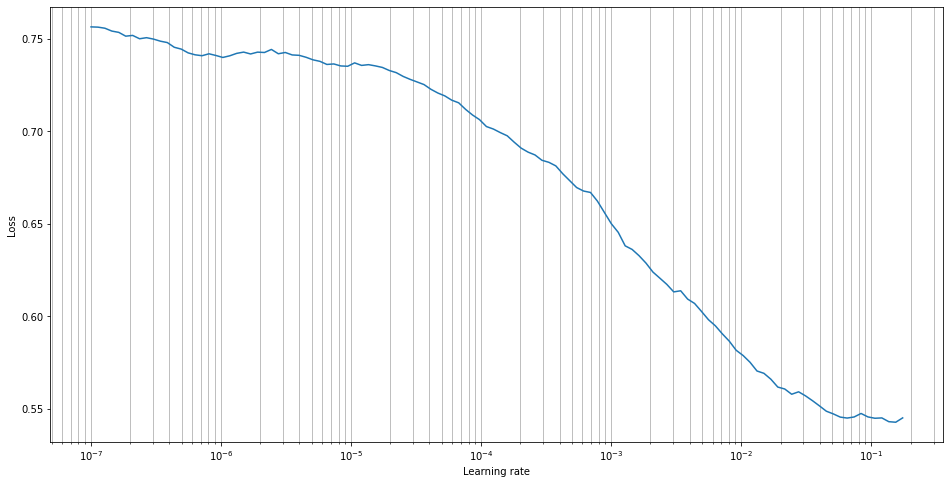

In [67]:
if Config.use_lr_finder:
    plot_lr_finder(lrs[:-18], losses[:-18])

## Trainer

In [68]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion, 
        scheduler,
        valid_labels,
        best_valid_score,
        fold,
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.best_valid_score = best_valid_score
        self.valid_labels = valid_labels
        self.fold = fold

    
    def fit(self, epochs, train_loader, valid_loader, save_path): 
        train_losses = []
        valid_losses = []
#         global N_EPOCH_EXPLICIT  #tbs later
        for n_epoch in range(epochs):
            start_time = time.time()
            print('Epoch: ', n_epoch)
            N_EPOCH_EXPLICIT = n_epoch
            train_loss, train_preds = self.train_epoch(train_loader)
            valid_loss, valid_preds = self.valid_epoch(valid_loader)

            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

            if isinstance(self.scheduler, ReduceLROnPlateau):
                self.scheduler.step(valid_loss)
            valid_score = get_score(self.valid_labels, valid_preds)

            numbers = valid_score
            filename = Config.model_output_folder+f'score_epoch_{n_epoch}.json'          
            with open(filename, 'w') as file_object: 
                json.dump(numbers, file_object) 
            

            if self.best_valid_score < valid_score:
                self.best_valid_score = valid_score
                self.save_model(n_epoch, save_path+f'best_model.pth', train_preds, valid_preds)

            print('train_loss: ',train_loss)
            print('valid_loss: ',valid_loss)
            print('valid_score: ',valid_score)
            print('best_valid_score: ',self.best_valid_score)
            print('time used: ', time.time()-start_time)

            wandb.log({f"[fold{self.fold}] epoch": n_epoch+1, 
                      f"[fold{self.fold}] avg_train_loss": train_loss, 
                      f"[fold{self.fold}] avg_val_loss": valid_loss,
                      f"[fold{self.fold}] val_score": valid_score})        

        # fig,ax = plt.subplots(1,1,figsize=(15,7))
        # ax.plot(list(range(epochs)), train_losses, label="train_loss")
        # ax.plot(list(range(epochs)), valid_losses, label="val_loss")
        # fig.legend()
        # plt.show()            
            
    def train_epoch(self, train_loader):
        if Config.amp:
            scaler = GradScaler()
        self.model.train()
        losses = []
        train_loss = 0
        # preds = []
        for step, batch in enumerate(train_loader, 1):
            self.optimizer.zero_grad()
            X = batch[0].to(self.device,non_blocking=Config.non_blocking)
            targets = batch[1].to(self.device,non_blocking=Config.non_blocking)
            
            if Config.use_mixup:
                (X_mix, targets_a, targets_b, lam) = mixup_data(
                    X, targets, Config.mixup_alpha
                )
                with autocast(enabled=False):
                    outputs = self.model(X_mix).squeeze()
                    loss = mixed_criterion(self.criterion, outputs, targets_a, targets_b, lam)
            else:
                with autocast(enabled=False):
                    outputs = self.model(X).squeeze()
                    loss = self.criterion(outputs, targets)

                
            if Config.gradient_accumulation_steps > 1:
                loss = loss / Config.gradient_accumulation_steps
            scaler.scale(loss).backward()
          
            if (step) % Config.gradient_accumulation_steps == 0:
                scaler.step(self.optimizer)
                scaler.update()
            

            if (not isinstance(self.scheduler, ReduceLROnPlateau)):
                self.scheduler.step()

            # preds.append(outputs.sigmoid().to('cpu').detach().numpy())
            loss2 = loss.detach()

            wandb.log({f"[fold{self.fold}] loss": loss2,
                       f"[fold{self.fold}] lr": self.scheduler.get_last_lr()[0]})            

            # losses.append(loss2.item())
            losses.append(loss2)
            train_loss += loss2

            if (step) % Config.print_num_steps == 0:
                train_loss = train_loss.item() #synch once per print_num_steps instead of once per batch
                print(f'[{step}/{len(train_loader)}] ', 
                      f'avg loss: ',train_loss/step,
                      f'inst loss: ', loss2.item())
                
        # predictions = np.concatenate(preds)

#         losses_avg = []
#         for i, loss in enumerate(losses):
#             if i == 0 :
#                 losses_avg.append(loss)
#             else:
#                 losses_avg.append(losses_avg[-1] * 0.6 + loss * 0.4)
#         losses = torch.stack(losses)
#         losses_avg = torch.stack(losses_avg)
#         fig,ax = plt.subplots(1,1,figsize=(15,7))
#         ax.plot(list(range(step)), losses, label="train_loss per step")
#         ax.plot(list(range(step)), losses_avg, label="train_loss_avg per step")
#         fig.legend()
#         plt.show()            
        
        return train_loss / step, None#, predictions

    def valid_epoch(self, valid_loader):
        self.model.eval()      
        valid_loss = []
        preds = []
        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch[0].to(self.device,non_blocking=Config.non_blocking)
                targets = batch[1].to(self.device,non_blocking=Config.non_blocking)
                outputs = self.model(X).squeeze()
                loss = self.criterion(outputs, targets)
                if Config.gradient_accumulation_steps > 1:
                    loss = loss / Config.gradient_accumulation_steps
                valid_loss.append(loss.detach().item())
                preds.append(outputs.sigmoid().to('cpu').numpy())
#                 valid_loss.append(loss.detach())#.item())
#                 preds.append(outputs.sigmoid())#.to('cpu').numpy())
#         valid_loss = torch.cat(valid_loss).to('cpu').numpy()
#         predictions = torch.cat(preds).to('cpu').numpy()
        predictions = np.concatenate(preds)
        return np.mean(valid_loss), predictions

    def save_model(self, n_epoch, save_path, train_preds, valid_preds):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
                'scheduler': self.scheduler.state_dict(),
                'train_preds': train_preds,
                'valid_preds': valid_preds,
            },
            save_path,
        )
    


# Training loop

In [69]:
seed_torch(seed=Config.seed)

In [70]:
# def check_PL(fold):
#     up_thresh = Config.up_thresh
#     down_thresh = Config.down_thresh
#     pseudo_label_df = pd.read_csv(Config.pseudo_label_folder + f"test_Fold_{fold}.csv") 
#     pseudo_label_df.head()
#     pseudo_label_df["target"] = pseudo_label_df[f'preds_Fold_{fold}']#or adding tta
#     num_test = pseudo_label_df.shape[0]
#     num_yes = (pseudo_label_df["target"] >= up_thresh).sum()
#     num_no = (pseudo_label_df["target"] <= down_thresh).sum()
#     num_all = num_yes+num_no
#     print("{:.2%} ratio, {:.2%} 1, {:.2%} 0".format(num_all/num_test, num_yes/num_test, num_no/num_test))
#     print(num_all)

In [71]:
# if Config.use_pseudo_label:
#     for fold in Config.train_folds:
#         check_PL(fold)

## non-leaky PL

In [72]:
def generate_PL(fold,up_thresh,down_thresh,train_df,test_df):
    pseudo_label_df = pd.read_csv(Config.pseudo_label_folder + f"test_Fold_{fold}.csv") 
    
    #soft labels
    pseudo_label_df["target"] = pseudo_label_df[f'preds_Fold_{fold}']
    
    #harden labels
#     test_df_2 = pseudo_label_df[(pseudo_label_df["target"] >= up_thresh) | (pseudo_label_df["target"] <= down_thresh)].copy()
#     test_df_2["target"] = (test_df_2["target"] >= up_thresh).astype(int)
#     test_df_2 = test_df_2.merge(test_df[["id","file_path"]],on="id",how="left") #no need for this line if already has path
    test_df_2 = pseudo_label_df.copy()
    test_df_2['fold'] = Config.n_fold
    PL_train_df = pd.concat([train_df, test_df_2]).reset_index(drop=True)
    PL_train_df.reset_index(inplace=True, drop=True)
#         display(train_df_PL.groupby('fold')['target'].apply(lambda s: s.value_counts(normalize=True)))
#         display(train_df_PL.shape)
#         display(train_df_PL)
    return PL_train_df

In [73]:
#generate_PL(fold,Config.up_thresh,Config.down_thresh,train_df.copy(),test_df) 

In [74]:
def training_loop(train_df, use_checkpoint=Config.use_checkpoint):
    kf = StratifiedKFold(n_splits=Config.n_fold, shuffle=True, random_state=Config.seed)
    avg_best_valid_score = 0
    folds_val_score = []
    original_train_df = train_df.copy()#for PL
    for fold in range(Config.n_fold): 
        if Config.use_pseudo_label:
            PL_train_df = generate_PL(fold,Config.up_thresh,Config.down_thresh,original_train_df.copy(),test_df)   
            train_df = PL_train_df
        train_index, valid_index = train_df.query(f"fold!={fold}").index, train_df.query(f"fold=={fold}").index #fold means fold_valid 
        print('Fold: ', fold)
        if fold not in Config.train_folds:
            print("skip")
            continue
        train_X, valid_X = train_df.loc[train_index], train_df.loc[valid_index]
        valid_labels = train_df.loc[valid_index,Config.target_col].values
#         fold_indices = pd.read_csv(f'{Config.gdrive}/Fold_{fold}_indices.csv')#saved fold ids
        oof = pd.DataFrame()
        oof['id'] = train_df.loc[valid_index,'id']
        oof['id'] = valid_X['id'].values.copy()
        oof = oof.reset_index()
        # assert oof['id'].eq(fold_indices['id']).all()
#         if not Config.use_subset:
#             assert oof['id'].eq(fold_indices['id']).sum()==112000
        oof['target'] = valid_labels
        
        oof.to_csv(f'{Config.model_output_folder}/Fold_{fold}_oof_pred.csv')
        # continue # uncomment this is to check oof ids

        print('training data samples, val data samples: ', len(train_X) ,len(valid_X))
        train_data_retriever = DataRetriever(train_X["file_path"].values, train_X["target"].values, transforms=train_transform)#how to run this only once and use for next experiment?
        valid_data_retriever = DataRetrieverTest(valid_X["file_path"].values, valid_X["target"].values, transforms=test_transform)        
        train_loader = DataLoader(train_data_retriever,
                                  batch_size=Config.batch_size, 
                                  shuffle=True, 
                                  num_workers=Config.num_workers, pin_memory=True, drop_last=False)
        valid_loader = DataLoader(valid_data_retriever, 
                                  batch_size=Config.batch_size * 2, 
                                  shuffle=False, 
                                  num_workers=Config.num_workers, pin_memory=True, drop_last=False)

        model = Model()
        model.to(device,non_blocking=Config.non_blocking)
        optimizer = AdamW(model.parameters(), lr=Config.lr,eps=1e-04, weight_decay=Config.weight_decay, amsgrad=False) #eps to avoid NaN/Inf in training loss
        scheduler = get_scheduler(optimizer, len(train_X))
        best_valid_score = -np.inf
        if use_checkpoint:
            print("Load Checkpoint, epo")
            checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            best_valid_score = float(checkpoint['best_valid_score'])
            scheduler.load_state_dict(checkpoint['scheduler'])
        
        
        criterion = torch_functional.binary_cross_entropy_with_logits
        

        trainer = Trainer(
            model, 
            device, 
            optimizer, 
            criterion,
            scheduler,
            valid_labels,
            best_valid_score,
            fold
        )

        history = trainer.fit(
            epochs=Config.epochs, 
            train_loader=train_loader, 
            valid_loader=valid_loader,
            save_path=f'{Config.model_output_folder}/Fold_{fold}_',
        )
        folds_val_score.append(trainer.best_valid_score)
        del train_data_retriever
    wandb.finish()
    print('folds score:', folds_val_score)
    print("Avg: {:.5f}".format(np.mean(folds_val_score)))
    print("Std: {:.5f}".format(np.std(folds_val_score)))
    

# Weight & Bias Initialization

In [75]:
wandb.login(key="1b0833b15e81d54fad9cfbbe3d923f57562a6f89")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/.netrc


True

In [76]:
job_type= "debug" if Config.debug else "train"
# run = wandb.init(project="G2Net", name=Config.model_version, config=class2dict(Config), group=Config.model_name, job_type=job_type)
run = wandb.init(project="G2Net", name=Config.model_version, config=class2dict(Config), group=Config.model_name, job_type=Config.model_version)


CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



# Train

In [77]:
%%time
try:
#     %lprun -f DataRetriever.__getitem__ -f Trainer.train_epoch -f Trainer.fit -f Trainer.valid_epoch training_loop() 
    training_loop(train_df,Config.use_checkpoint)
except RuntimeError as e:
    gc.collect()
    torch.cuda.empty_cache()   
    print(e)# saving oof predictions

Fold:  0
training data samples, val data samples:  674000 112000
V2SDCBAM
Epoch:  0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.5110068620954241 inst loss:  0.44457563757896423
[700/2633]  avg loss:  0.4687482561383929 inst loss:  0.44863206148147583
[1050/2633]  avg loss:  0.4513379196893601 inst loss:  0.3859938383102417
[1400/2633]  avg loss:  0.44009647914341515 inst loss:  0.40524232387542725
[1750/2633]  avg loss:  0.43237193080357145 inst loss:  0.35278525948524475
[2100/2633]  avg loss:  0.4267700776599702 inst loss:  0.362128883600235
[2450/2633]  avg loss:  0.422255859375 inst loss:  0.39610034227371216


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.4204, device='cuda:0')
valid_loss:  0.42637498778839633
valid_score:  0.8750649642897745
best_valid_score:  0.8750649642897745
time used:  570.5144779682159
Epoch:  1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.39110613141741074 inst loss:  0.42305994033813477
[700/2633]  avg loss:  0.39087223597935267 inst loss:  0.41152483224868774
[1050/2633]  avg loss:  0.3901913597470238 inst loss:  0.3835468590259552
[1400/2633]  avg loss:  0.39009695870535716 inst loss:  0.3615749776363373
[1750/2633]  avg loss:  0.3894356515066964 inst loss:  0.35822197794914246
[2100/2633]  avg loss:  0.3887672061011905 inst loss:  0.3435099124908447
[2450/2633]  avg loss:  0.38842372349330356 inst loss:  0.36138856410980225


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3882, device='cuda:0')
valid_loss:  0.4057838060812319
valid_score:  0.8787377674529983
best_valid_score:  0.8787377674529983
time used:  570.299928188324
Epoch:  2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3806362043108259 inst loss:  0.42745405435562134
[700/2633]  avg loss:  0.3813029261997768 inst loss:  0.381150484085083
[1050/2633]  avg loss:  0.3823302060081845 inst loss:  0.437661349773407
[1400/2633]  avg loss:  0.38204254150390626 inst loss:  0.39919450879096985
[1750/2633]  avg loss:  0.3820068359375 inst loss:  0.3569439649581909
[2100/2633]  avg loss:  0.38160298665364584 inst loss:  0.35844627022743225
[2450/2633]  avg loss:  0.3814984006297832 inst loss:  0.4145825505256653


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3813, device='cuda:0')
valid_loss:  0.40118193218152814
valid_score:  0.8798835192784342
best_valid_score:  0.8798835192784342
time used:  571.341135263443
Epoch:  3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3778019060407366 inst loss:  0.38965171575546265
[700/2633]  avg loss:  0.37742723737444195 inst loss:  0.3905324637889862
[1050/2633]  avg loss:  0.3769336809430804 inst loss:  0.37901031970977783
[1400/2633]  avg loss:  0.3766016932896205 inst loss:  0.3427102863788605
[1750/2633]  avg loss:  0.3763491908482143 inst loss:  0.397398978471756
[2100/2633]  avg loss:  0.37605657668340775 inst loss:  0.38928139209747314
[2450/2633]  avg loss:  0.37549592932876275 inst loss:  0.3957338333129883


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3754, device='cuda:0')
valid_loss:  0.4087719601583263
valid_score:  0.8806297656579828
best_valid_score:  0.8806297656579828
time used:  570.8083019256592
Epoch:  4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3731123570033482 inst loss:  0.34809553623199463
[700/2633]  avg loss:  0.37108799525669645 inst loss:  0.3579268455505371
[1050/2633]  avg loss:  0.3704957217261905 inst loss:  0.3678751289844513
[1400/2633]  avg loss:  0.3706329345703125 inst loss:  0.3745664358139038
[1750/2633]  avg loss:  0.36999319893973215 inst loss:  0.386250376701355
[2100/2633]  avg loss:  0.36988688151041665 inst loss:  0.34248268604278564
[2450/2633]  avg loss:  0.3697311463647959 inst loss:  0.4049832224845886


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3695, device='cuda:0')
valid_loss:  0.40624334850267735
valid_score:  0.8813895300549579
best_valid_score:  0.8813895300549579
time used:  571.057210445404
Epoch:  5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.36400604248046875 inst loss:  0.3634847402572632
[700/2633]  avg loss:  0.36559454781668527 inst loss:  0.3478764295578003
[1050/2633]  avg loss:  0.36558771042596727 inst loss:  0.3488766551017761
[1400/2633]  avg loss:  0.36468475341796874 inst loss:  0.33334654569625854
[1750/2633]  avg loss:  0.36465182059151785 inst loss:  0.35670408606529236
[2100/2633]  avg loss:  0.3648692394438244 inst loss:  0.3611897826194763
[2450/2633]  avg loss:  0.3650308165258291 inst loss:  0.3838743567466736


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3650, device='cuda:0')
valid_loss:  0.40561510561263725
valid_score:  0.8815154501840012
best_valid_score:  0.8815154501840012
time used:  570.7957179546356
Fold:  1
skip
Fold:  2
skip
Fold:  3
skip
Fold:  4
skip


[fold0] avg_train_loss,0.365
[fold0] avg_val_loss,0.40562
[fold0] epoch,6
[fold0] loss,0.35093
[fold0] lr,0.0
[fold0] val_score,0.88152


[fold0] avg_train_loss,█▄▃▂▂▁
[fold0] avg_val_loss,█▂▁▃▂▂
[fold0] epoch,▁▂▄▅▇█
[fold0] loss,█▄▆▅▄▅▅▅▇▂▄▆▃▄▆▅▁▂▄▅▅▄▃▄▂▄▂▃▃▄▁▃▃▂▃▃▂▄▃▃
[fold0] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
[fold0] val_score,▁▅▆▇██


folds score: [0.8815154501840012]
Avg: 0.88152
Std: 0.00000
CPU times: user 55min 17s, sys: 3min 26s, total: 58min 44s
Wall time: 57min 13s


In [78]:
pass

# Pause

In [40]:
print(Config.train_folds)

[0, 1, 2, 3, 4]


In [41]:
# %%javascript
# import Ipython
# IPython.notebook.save_notebook()

In [42]:
from time import sleep
sleep(120)

In [43]:
# from jarviscloud import jarviscloud
# jarviscloud.pause()

In [44]:
for fold in Config.train_folds:
    print(fold)
    checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
    # print(checkpoint['valid_preds'])
    try:
        # oof = pd.read_csv(f'{Config.gdrive}/Fold_{fold}_indices.csv') also works, used in replacement of next statement for previously not generated Fold_{fold}_oof_pred.csv
        oof = pd.read_csv(f'{Config.model_output_folder}/Fold_{fold}_oof_pred.csv')
        oof['pred'] = checkpoint['valid_preds']
        oof.to_csv(f'{Config.model_output_folder}/Fold_{fold}_oof_pred.csv') 
        print('successfully saved oof predictions for Fold: ', fold)   
    except:
        raise RuntimeError('failure in saving predictions for Fold: ', fold)

0
successfully saved oof predictions for Fold:  0
1
successfully saved oof predictions for Fold:  1
2
successfully saved oof predictions for Fold:  2
3
successfully saved oof predictions for Fold:  3
4
successfully saved oof predictions for Fold:  4


# add TTA

In [45]:
# dataset

In [46]:
#tbs need pythonic way
class TTA(Dataset):
    def __init__(self, paths, targets, vflip=False, shuffle_channels=False, time_shift=False, 
                 add_gaussian_noise = False,  time_stretch=False,shuffle01=False,timemask=False,
                 shift_channel=False,reduce_SNR=False, ):
        self.paths = paths
        self.targets = targets
        self.vflip = vflip
        self.shuffle_channels = shuffle_channels
        self.time_shift = time_shift
        self.add_gaussian_noise = add_gaussian_noise
        self.time_stretch = time_stretch
        self.shuffle01 = shuffle01
        self.timemask = timemask
        self.shift_channel = shift_channel
        self.reduce_SNR = reduce_SNR
        if time_shift:
            self.time_shift = A.Shift(min_fraction=-Config.time_shift_left*1.0/4096, 
                                      max_fraction=Config.time_shift_right*1.0/4096, p=1,rollover=False)
        if add_gaussian_noise:
            self.add_gaussian_noise = A.AddGaussianNoise(min_amplitude=0.001*0.015, max_amplitude= 0.015*0.015, p=1)
        if time_stretch:
            self.time_stretch = A.TimeStretch(min_rate=0.9, max_rate=1.111,leave_length_unchanged=True, p=1)
        if timemask:
            self.timemask = A.TimeMask(min_band_part=0.0, max_band_part=0.03, fade=False, p=1.0)

              
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index] 
        waves = np.load(path)

#         if Config.divide_std:
#             waves /= 0.015

        if self.vflip:
            waves = -waves
        if self.shuffle_channels:
            np.random.shuffle(waves)
        if self.time_shift:
            waves = self.time_shift(waves, sample_rate=2048)
        if self.add_gaussian_noise:
            waves = self.add_gaussian_noise(waves, sample_rate=2048)
        if self.time_stretch:
            waves = self.time_stretch(waves, sample_rate=2048)
        if self.shuffle01:
            waves[[0,1]] = waves[[1,0]]
        if self.timemask:
            waves = self.timemask(waves, sample_rate=2048)
        if self.shift_channel:
            waves = shift_channel_func(waves, sample_rate=2048)
        if self.reduce_SNR:
            waves = reduce_SNR_func(waves, sample_rate=2048)
        #snr, shift_channel tba
        
        waves = torch.from_numpy(waves) 
        target = torch.tensor(self.targets[index],dtype=torch.float)#device=device,             
        return (waves, target)

In [47]:
## functions for making predictions

In [48]:
def get_pred(loader,model):
    preds = []
    for step, batch in enumerate(loader, 1):
        if step % Config.print_num_steps == 0:
            print("step {}/{}".format(step, len(loader)))
        with torch.no_grad():
            X = batch[0].to(device,non_blocking=Config.non_blocking)
            outputs = model(X).squeeze()
            preds.append(outputs.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

def get_tta_pred(df,model,**transforms):
    data_retriever = TTA(df['file_path'].values, df['target'].values, **transforms)
    loader = DataLoader(data_retriever, 
                            batch_size=Config.batch_size * 2, 
                            shuffle=False, 
                            num_workers=Config.num_workers, pin_memory=True, drop_last=False)
    return get_pred(loader,model)

     

In [49]:
##TTA for oof
print(conserv_transform_list_strings)
print(aggressive_transform_list_strings)

[]
['vflip', 'add_gaussian_noise', 'timemask', 'shuffle01', 'time_shift']


In [50]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
conserv_transform_powerset = list(powerset(conserv_transform_list_strings))
conserv_transform_powerset

[()]

In [51]:
for transformations in conserv_transform_powerset:
    print({transformation:True for transformation in transformations})

{}


## generate oof tta

In [52]:

model = Model()

for fold in Config.train_folds:
    print('Fold ',fold)
    oof = train_df.query(f"fold=={fold}").copy()
    oof['preds'] = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')['valid_preds']
    oof['file_path'] = train_df['id'].apply(lambda x :id_2_path(x))
    # display(oof)    

    checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device=device,non_blocking=Config.non_blocking)
    model.eval()
    
    for transformations in conserv_transform_powerset:
#         print(transformations)
        if transformations:#to avoid double count original
            print("tta_"+('_').join(transformations))
            oof["tta_"+('_').join(transformations)] = get_tta_pred(oof,model,**{transformation:True for transformation in transformations})
        for aggr_transformation in aggressive_transform_list_strings:#tbs combination of conservative and aggressive
            print("tta_"+('_').join(transformations)+'_'+aggr_transformation)
            oof["tta_"+('_').join(transformations)+'_'+aggr_transformation] = get_tta_pred(oof,model,**{transformation:True for transformation in transformations}, **{aggr_transformation:True})
               

    oof.to_csv(Config.model_output_folder + f"/oof_Fold_{fold}.csv", index=False)
    


ModelIafossV2
Fold  0
tta__vflip


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__add_gaussian_noise


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__timemask


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__shuffle01


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__time_shift


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Fold  1
tta__vflip


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__add_gaussian_noise


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__timemask


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__shuffle01


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__time_shift


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Fold  2
tta__vflip


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__add_gaussian_noise


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__timemask


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__shuffle01


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__time_shift


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Fold  3
tta__vflip


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__add_gaussian_noise


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__timemask


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__shuffle01


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__time_shift


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Fold  4
tta__vflip


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__add_gaussian_noise


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__timemask


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__shuffle01


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__time_shift


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [53]:
oof_all = pd.DataFrame()
for fold in Config.train_folds:
    oof = pd.read_csv(Config.model_output_folder + f"/oof_Fold_{fold}.csv")
    oof_all = pd.concat([oof_all,oof])

In [54]:
# ('_').join(transformations)


In [55]:
print("Original:",roc_auc_score(oof_all['target'], oof_all['preds']))

for col in oof_all.columns:
    if "tta" in col:
        print(col,roc_auc_score(oof_all['target'], oof_all[col]))

Original: 0.8801739879573027
tta__vflip 0.8802155890695967
tta__add_gaussian_noise 0.8801488065845556
tta__timemask 0.8779151828990358
tta__shuffle01 0.8796113994017328
tta__time_shift 0.8787075903592754


In [56]:
oof_sample = oof_all[oof_all['fold']==2]
roc_auc_score(oof_sample['target'], oof_sample['preds'])

0.880162177937432

In [57]:
oof_all['avg']=0
total_weight = 0
#weights leaky? not fine tuned

oof_weight  = defaultdict(lambda :1)
aggr_total_weight = 0
for trans in aggressive_transform_list_strings:
    aggr_total_weight += getattr(Config(),trans+'_weight')

for col in oof_all.columns:
    
    if 'tta_' in col or 'preds' in col: 
        for trans in conserv_transform_list_strings:
            
            if trans in col:
                oof_weight[col] *= getattr(Config(),trans+'_proba')
            else:
                oof_weight[col] *= 1-getattr(Config(),trans+'_proba')
            
        flag = False
        for trans in aggressive_transform_list_strings:
            
            if trans in col:
                oof_weight[col] *= getattr(Config(),trans+'_weight')/aggr_total_weight*Config.aggressive_aug_proba
                
                flag = True
        if not flag:
            oof_weight[col] *= (1-Config.aggressive_aug_proba)
        
print(oof_weight)
for key,value in oof_weight.items():
    print(key,value)

for col in oof_all.columns:
    if ('tta_' in col or 'preds' in col): # and 'time_shift' not in col and 'timemask' not in col
        print(col)
        total_weight+=oof_weight[col]
        oof_all['avg'] += oof_all[col]*oof_weight[col]
oof_all['avg'] /= total_weight

print("preds_tta_avg:",roc_auc_score(oof_all['target'], oof_all['avg']))

oof_all.to_csv(Config.model_output_folder + "/oof_all.csv", index=False)
oof_all[['id','fold','avg']].rename(columns={'id':'id','fold':'fold','avg':'prediction'}).to_csv(Config.model_output_folder + "/oof_final.csv", index=False)

defaultdict(<function <lambda> at 0x7f727009f8b0>, {'preds': 0.19999999999999996, 'tta__vflip': 0.20000000000000007, 'tta__add_gaussian_noise': 0.20000000000000007, 'tta__timemask': 0.16000000000000003, 'tta__shuffle01': 0.16000000000000003, 'tta__time_shift': 0.08000000000000002})
preds 0.19999999999999996
tta__vflip 0.20000000000000007
tta__add_gaussian_noise 0.20000000000000007
tta__timemask 0.16000000000000003
tta__shuffle01 0.16000000000000003
tta__time_shift 0.08000000000000002
preds
tta__vflip
tta__add_gaussian_noise
tta__timemask
tta__shuffle01
tta__time_shift
preds_tta_avg: 0.880417961697041


## generate TTA for test

In [ ]:
%%time 
test_df['target'] = 0  
model = Model()

for fold in Config.train_folds:
    test_df2 = test_df.copy()
    checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device=device,non_blocking=Config.non_blocking)
    model.eval()

    test_df2['preds'+f'_Fold_{fold}'] = get_tta_pred(test_df2,model)

    for transformations in conserv_transform_powerset:
#         print(transformations)
        if transformations:#to avoid double count original
            print("tta_"+('_').join(transformations)+f'_Fold_{fold}')
            test_df2["tta_"+('_').join(transformations)+f'_Fold_{fold}'] = get_tta_pred(test_df2,model,**{transformation:True for transformation in transformations})
        for transformation in aggressive_transform_list_strings:#tbs combination of conservative and aggressive
            print("tta_"+('_').join(transformations)+'_'+transformation+f'_Fold_{fold}')
            test_df2["tta_"+('_').join(transformations)+'_'+transformation+f'_Fold_{fold}'] = get_tta_pred(test_df2,model,**{transformation:True for transformation in transformations}, **{transformation:True})
               
    test_df2.to_csv(Config.model_output_folder + f"/test_Fold_{fold}.csv", index=False)


ModelIafossV2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__vflip_Fold_0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__add_gaussian_noise_Fold_0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__timemask_Fold_0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__shuffle01_Fold_0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__time_shift_Fold_0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__vflip_Fold_1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__add_gaussian_noise_Fold_1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__timemask_Fold_1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__shuffle01_Fold_1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__time_shift_Fold_1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__vflip_Fold_2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__add_gaussian_noise_Fold_2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__timemask_Fold_2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__shuffle01_Fold_2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__time_shift_Fold_2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__vflip_Fold_3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__add_gaussian_noise_Fold_3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__timemask_Fold_3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__shuffle01_Fold_3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__time_shift_Fold_3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__vflip_Fold_4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__add_gaussian_noise_Fold_4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__timemask_Fold_4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__shuffle01_Fold_4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [ ]:
test_avg = test_df[['id', 'target']].copy()
test_avg['target'] = 0
# print(test_avg.describe())

total_weight = 0
for fold in Config.train_folds:
#     test_weight = {key+f'_Fold_{fold}':value for key,value in oof_weight.items()}
    test_weight = oof_weight #defaultdict(lambda:1)
    test_df2 = pd.read_csv(Config.model_output_folder + f"/test_Fold_{fold}.csv")
#     print(test_df2.describe())
    for col in test_df2.columns:
        col_weight = col.split('_Fold_')[0]
        if ('tta_' in col or 'preds' in col): 
#             print(col)
#             print(test_weight[col_weight])
            total_weight+=test_weight[col_weight]
            test_avg['target'] += test_df2[col]*test_weight[col_weight]
test_avg['target'] /= total_weight
print(test_avg.describe())
print(test_avg["target"].hist(bins=100))
print(test_avg)
# print(total_weight)
test_avg.to_csv(Config.model_output_folder + "/test_avg.csv", index=False)

In [ ]:
# Create Submission File

In [ ]:
test_avg[['id', 'target']].to_csv("./submission.csv", index=False)

test_avg[['id', 'target']].to_csv(Config.model_output_folder + "/submission.csv", index=False)

!mkdir -p ~/.kaggle/ && cp $Config.kaggle_json_path ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle competitions submit -c g2net-gravitational-wave-detection -f ./submission.csv -m $Config.model_version

In [ ]:
from jarviscloud import jarviscloud
jarviscloud.pause()

In [ ]:
# !tar -cf  $Config.model_version  -C  $Config.model_output_folder .